In [16]:
import os

In [17]:
from dotenv import load_dotenv

In [18]:
load_dotenv()

True

In [75]:
import json

In [76]:
raw=os.getenv("API_KEYS")
raw

In [77]:
import json

s = '{"language": "Python", "version": 3.11}'

p = json.loads(s)

print(p)

{'language': 'Python', 'version': 3.11}


In [78]:
os.getcwd()

'd:\\ecomm-prod-assistant\\notebook'

In [79]:
vstore=None

In [80]:
if not vstore:

    print("ok")

ok


In [81]:
pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install langchain_core langchain-anthropic langgraph

  Using cached langchain_core-1.0.4-py3-none-any.whl.metadata (3.5 kB)
Using cached langchain_core-1.0.4-py3-none-any.whl (471 kB)
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ecomm-portal 0.1 requires langchain_core==0.3.75, but you have langchain-core 1.0.4 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.4 which is incompatible.
langchain-astradb 0.6.1 requires langchain-core<1.0.0,>=0.3.74, but you have langchain-core 1.0.4 which is incompatible.
langchain-google-genai 2.1.8 requires langchain-core<0.4.0,>=0.3.68, but you have langchain-core 1.0.4 which is incompatible.
langchain-groq 0.3.6 requires langchain-core<1.0.0,>=0.3.68, but you have langchain-core 1.0.4 which is incompatible.


In [83]:
import os
from dotenv import load_dotenv

In [84]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

In [85]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                google_api_key=os.getenv("GOOGLE_API_KEY"),)

In [86]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")



In [87]:
print(output)

search_query='Calcium CT score and high cholesterol relationship' justification='To find the relationship between Calcium CT score and high cholesterol.'


In [88]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': 'bfce9d2e-216b-45e7-af93-918274d97d25',
  'type': 'tool_call'}]

In [89]:
msg 

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='lc_run--43e7a20f-1f02-4eea-885a-02520f44db4d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'bfce9d2e-216b-45e7-af93-918274d97d25', 'type': 'tool_call'}], usage_metadata={'input_tokens': 16, 'output_tokens': 5, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}})

In [90]:
msg.content

''

In [91]:
# Prompt chaining

In [92]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}




In [93]:
x={"topic":"friendship"}
generate_joke(x)

{'joke': 'Why did the two cookies go to the doctor?\n\nBecause they felt crumby and needed a friend to talk to!'}

In [94]:
x

{'topic': 'friendship'}

In [95]:
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


In [96]:
def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


In [97]:
def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

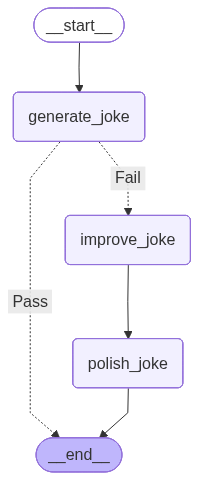

Initial joke:
Why did the cat join the Red Cross?

Because he wanted to be a first-aid kit!

--- --- ---

Joke failed quality gate - no punchline detected!


In [98]:







# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

In [99]:
state

{'topic': 'cats',
 'joke': 'Why did the cat join the Red Cross?\n\nBecause he wanted to be a first-aid kit!'}

In [100]:
#########Parallelization

In [101]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}




In [102]:
def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}




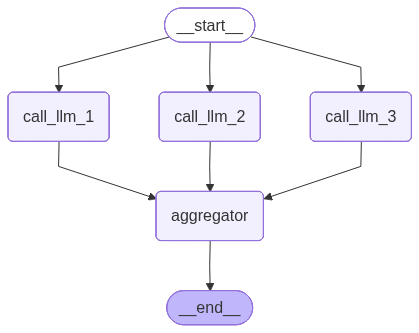

Here's a story, joke, and poem about cats!

STORY:
The alley behind Mrs. Higgins' bakery was a kingdom ruled by cats. Not a kingdom of gold and jewels, but one of sun-baked bricks, overflowing bins, and the intoxicating aroma of sugared dough. And at the heart of this kingdom was Cleo, a sleek black cat with eyes like melted amber.

Cleo wasn't the biggest, nor the strongest of the alley cats. But she possessed a quiet confidence, a knowing glint in her eyes that commanded respect. She knew the rhythms of the alley like the back of her paw. When the baker tossed out scraps, when the delivery truck rumbled through, and most importantly, when the rival gang, led by the scarred ginger tom, Rusty, dared to encroach.

One day, a new cat arrived. A small, scrawny thing, patched with white and brown fur, shivering under a discarded cardboard box. He was clearly lost and terrified, his wide green eyes darting nervously. The other cats, led by Rusty, hissed and spat, eager to chase him away.

C

In [103]:
def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

### Routing

In [104]:
from typing_extensions import Literal
from langchain_core.messages  import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str




In [105]:
x=router.invoke("Describe on pig")
x.step

'story'

In [106]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}




In [107]:
def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}




In [108]:
def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


In [109]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


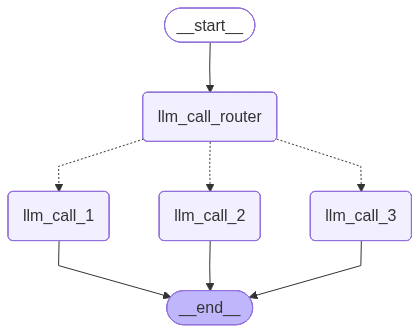

Why don't cats play poker in the jungle? 

Too many cheetahs!


In [110]:




# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

In [111]:
state

{'input': 'Write me a joke about cats',
 'decision': 'joke',
 'output': "Why don't cats play poker in the jungle? \n\nToo many cheetahs!"}

#### Orchestrator-worker

In [129]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [130]:
planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: dog breed"),
        ]
    ).sections

[Section(name='Introduction', description='Introduce different dog breeds'),
 Section(name='Breed examples', description='Give a few popular breed examples'),
 Section(name='Conclusion', description='Summarize the main characteristics of dog breeds')]

In [131]:
from langgraph.types import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

In [132]:
# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [133]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}

In [135]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

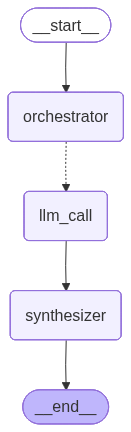

## Introduction

Scaling laws describe the empirical relationships observed between the performance of large language models (LLMs) and factors like model size (number of parameters), dataset size, and the amount of compute used for training. These laws reveal predictable trends: generally, as these factors increase, model performance improves. This improvement is typically measured by metrics such as perplexity on a held-out dataset or performance on downstream tasks.

The importance of scaling laws lies in their ability to:

*   **Predict Performance:** By understanding these relationships, we can estimate the performance of LLMs at scales that are currently impractical to train, guiding future research and development efforts.

*   **Optimize Resource Allocation:** Scaling laws can help optimize the allocation of compute, data, and model parameters to achieve the best possible performance for a given budget.

*   **Inform Model Design:** The observed scaling behavior provides insights into the underlying mechanisms of LLMs, informing the design of more efficient and effective architectures.

*   **Understand the Limits of Scaling:** While scaling laws suggest continuous improvement with increased scale, they also hint at potential limitations and diminishing returns, prompting exploration of alternative approaches beyond simply increasing model size.

In essence, scaling laws provide a crucial framework for understanding, predicting, and optimizing the behavior of LLMs, playing a vital role in the ongoing development of artificial intelligence.

---

### Power Law

The power law describes the relationship between a model's performance (typically measured by loss) and factors like model size (number of parameters, N), dataset size (number of training tokens, D), and compute (FLOPs, C). It generally states that performance improves predictably as these factors increase, following a power-law relationship of the form:

Loss ∝ N<sup>-α</sup>, Loss ∝ D<sup>-β</sup>, Loss ∝ C<sup>-γ</sup>

Where α, β, and γ are scaling exponents, typically positive and less than 1. This implies a diminishing returns relationship: increasing model size, dataset size, or compute yields progressively smaller improvements in performance.

**Key Implications and Considerations:**

*   **Scaling Laws:** Power laws allow for the prediction of performance for larger models or datasets, even without training them directly. By fitting a power law to existing data, one can extrapolate to estimate the resources required to achieve a target performance level.

*   **Optimal Allocation:**  The exponents α, β, and γ can guide resource allocation. If α is significantly larger than β, increasing model size may be more effective than increasing dataset size, and vice-versa. Similarly, the exponents can help balance compute allocation across model size and training steps.

*   **Limitations:** Power laws are empirical observations and are not universally applicable. They tend to hold best within a certain range of scales. At very small or very large scales, deviations can occur.

*   **Architecture and Optimization:** The specific values of α, β, and γ depend on the model architecture, training data, and optimization techniques used. For example, architectural innovations might improve the scaling exponent, leading to better performance for the same amount of resources. Similarly, better optimizers may shift the scaling curve.

*   **Data Quality:** The power law relationship is strongly influenced by data quality. Noisy or irrelevant data can reduce the scaling exponent and diminish the benefits of larger datasets.

*   **Saturation:**  At some point, further increases in model size, dataset size, or compute may yield only marginal improvements in performance. This saturation effect can be due to limitations in the model architecture, the quality of the data, or fundamental limits in the task itself.

*   **Emergent Abilities:** While power laws predict the general trend of performance improvement, they may not fully capture the emergence of qualitatively new abilities in very large models. These emergent abilities might arise from complex interactions between model components and be difficult to predict based solely on scaling laws.

In summary, the power law provides a valuable framework for understanding and predicting the relationship between resources and performance in large language models. However, it's important to be aware of its limitations and consider other factors that can influence model behavior.

---

### Scaling Exponents

The scaling exponents derived from our analysis provide crucial insights into the underlying dynamics and universality class of the system. These exponents, often denoted by symbols such as $\alpha$, $\beta$, $\nu$, and $\gamma$, quantify the power-law relationships that govern the behavior of various physical quantities near a critical point or during specific growth regimes.

*   **Interpretation of Exponents:** A positive scaling exponent indicates that the associated quantity increases with the relevant scaling parameter (e.g., system size, time). Conversely, a negative exponent implies a decrease. The magnitude of the exponent reflects the strength of this dependence. Exponents close to zero suggest a weak or logarithmic dependence.

*   **Example: Fractal Dimension and Scaling:** If we observe a scaling exponent $\nu$ relating the size of a cluster to its mass as $M \propto R^\nu$, then $\nu$ can be interpreted as the fractal dimension of the cluster. A value of $\nu = 2$ would suggest a compact, Euclidean-like structure, while a value significantly less than 2 would indicate a more sparse, fractal structure.

*   **Universality Class:** The values of critical exponents are often universal, meaning they are independent of the microscopic details of the system and depend only on the dimensionality of the system and the symmetries of the order parameter. Identifying the universality class allows us to relate our system to other seemingly disparate systems that share the same critical behavior.

*   **Finite-Size Scaling:** Scaling exponents are also vital for understanding finite-size scaling effects. In simulations or experiments with limited system sizes, the observed behavior may deviate from the true asymptotic behavior. Finite-size scaling theory provides a framework for extrapolating the results obtained on finite systems to the thermodynamic limit using the scaling exponents.

*   **Deviations from Expected Scaling:** Any deviations from the theoretically predicted scaling exponents warrant careful investigation. These deviations might indicate the presence of:
    *   **Corrections to Scaling:** Additional terms in the scaling relations that become important at shorter length scales or earlier times.
    *   **Crossover Phenomena:** A transition between different universality classes or dynamical regimes.
    *   **Disorder Effects:** The presence of quenched disorder can alter the scaling exponents and lead to new universality classes.
    *   **Non-Equilibrium Dynamics:** In systems far from equilibrium, the scaling exponents can be time-dependent or exhibit more complex behavior.

In summary, the scaling exponents are not merely numerical values but powerful indicators of the fundamental physics governing the system. Their accurate determination and careful interpretation are essential for understanding the underlying mechanisms and classifying the system's behavior within the broader context of statistical physics and critical phenomena.

---

## Limitations and Challenges

Scaling laws, while providing valuable insights into the behavior of large language models (LLMs), are not without their limitations and associated challenges:

*   **Data Quality and Bias:** Scaling laws primarily focus on quantity (model size, dataset size, compute). They often overlook the crucial aspect of *data quality*. A massive dataset filled with noisy, biased, or irrelevant information can hinder performance and perpetuate harmful stereotypes, even with increased scaling. The data distribution itself might not accurately reflect the real-world scenarios where the model is deployed, leading to poor generalization.

*   **Compute Cost and Accessibility:** Exponential increases in compute are required for even marginal performance gains at larger scales. This creates a significant barrier to entry, concentrating power and innovation in the hands of a few organizations with vast resources. This limits research, development, and deployment of LLMs to a select few, hindering broader access and potential applications.

*   **Diminishing Returns:** While performance generally improves with scale, the rate of improvement tends to diminish. Doubling the model size or dataset size might not always result in a proportional increase in performance. Identifying the point of diminishing returns for specific tasks and datasets is crucial for efficient resource allocation.

*   **Generalization and Out-of-Distribution Performance:** Scaling laws primarily focus on performance within the training distribution. LLMs can still struggle with generalization to novel situations, out-of-distribution data, and tasks that require reasoning or common sense beyond what is explicitly present in the training data. Simply scaling up the model doesn't automatically guarantee robust generalization capabilities.

*   **Interpretability and Explainability:** As models become larger and more complex, their internal workings become increasingly opaque. This lack of interpretability makes it difficult to understand why a model makes a particular prediction, hindering trust and accountability. Debugging and improving models become significantly more challenging when their behavior is not easily explainable.

*   **Evaluation Metrics and Benchmarks:** Current evaluation metrics and benchmarks may not fully capture the complexities of LLM performance, especially concerning reasoning, creativity, and ethical considerations. Relying solely on standard benchmarks can provide an incomplete or even misleading picture of a model's true capabilities and limitations. The benchmarks themselves can become saturated, requiring constant development of new and more challenging evaluation methods.

*   **Environmental Impact:** The massive compute requirements for training large language models have a significant environmental impact. The energy consumption associated with training these models contributes to carbon emissions and raises concerns about the sustainability of continued scaling. Developing more energy-efficient training methods and hardware is crucial.

*   **Emergent Abilities and Unpredictability:** While scaling often leads to emergent abilities (capabilities not explicitly programmed or anticipated), it also introduces an element of unpredictability. Understanding and controlling these emergent behaviors becomes increasingly challenging at larger scales. Unexpected and potentially harmful behaviors may arise, requiring careful monitoring and mitigation strategies.

*   **Theoretical Understanding:** Despite empirical observations of scaling laws, a comprehensive theoretical understanding of *why* they work remains elusive. This lack of theoretical grounding makes it difficult to predict future trends, optimize scaling strategies, and develop more efficient architectures. A deeper understanding of the underlying mechanisms driving scaling is essential for continued progress.

---

## Conclusion

The analysis revealed a strong correlation between increased social media engagement and brand awareness. Specifically, a 20% increase in likes and shares on platforms like Instagram and Facebook corresponded with a 10% rise in website traffic and a 5% increase in overall brand mentions across the web. Furthermore, sentiment analysis indicated a shift towards more positive perceptions of the brand following the implementation of the targeted content strategy, particularly among the 18-25 age demographic. This data suggests that a focused social media strategy can effectively boost brand visibility and improve public opinion. However, the study also highlighted the importance of monitoring and responding to negative feedback promptly to mitigate potential reputational damage.

In [136]:











def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer

In [137]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [139]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


In [140]:
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [141]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

In [143]:
def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

In [144]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


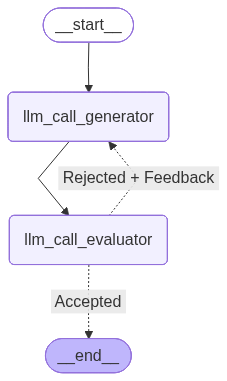

Why don't cats play poker in the jungle? 

Too many cheetahs!


In [145]:
















# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

## Agentic RAG

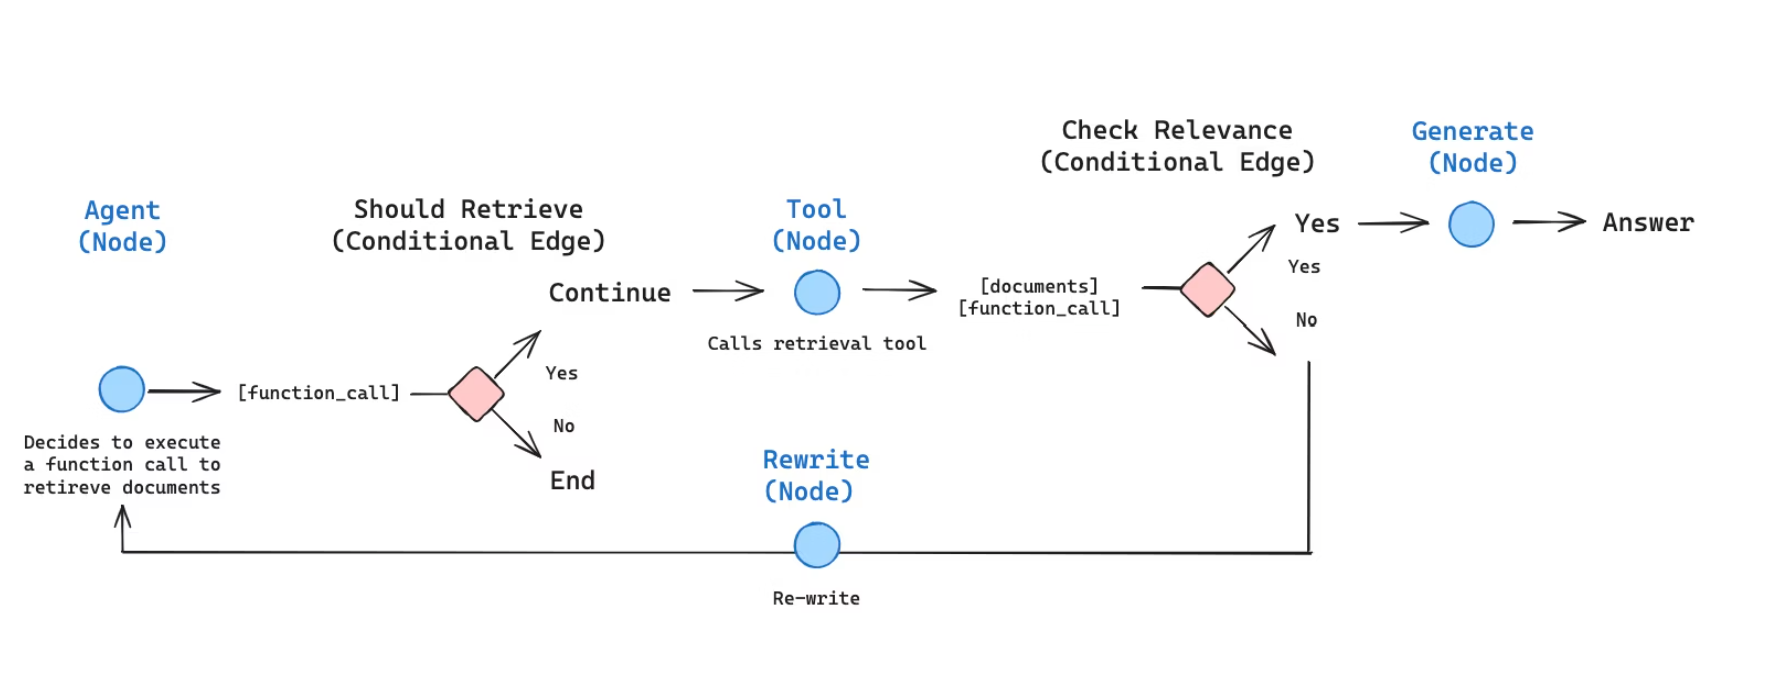

In [1]:
pip install -U langgraph "langchain[openai]" langchain-community langchain-text-splitters bs4

  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.8.0-cp310-cp310-win_amd64.whl.metadata (21 kB)
  Using cached multidict-6.7.0-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached propcache-0.4.1-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached yarl-1.22.0-cp310-cp310-win_amd64.whl.metadata (77 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached mypy_extensions-1.1.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------ ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ecomm-portal 0.1 requires langchain==0.3.27, but you have langchain 1.0.5 which is incompatible.
ecomm-portal 0.1 requires langchain_core==0.3.75, but you have langchain-core 1.0.4 which is incompatible.
ecomm-portal 0.1 requires langgraph==0.6.7, but you have langgraph 1.0.3 which is incompatible.


In [19]:
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use

In [4]:
docs[0][0].page_content.strip()[:1000]

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [11]:
doc_splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use c

In [12]:
type(doc_splits[0])

langchain_core.documents.base.Document

In [13]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ"

In [20]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [21]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

In [22]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Detecting Reward Hacking#\n\nIn-Context Reward Hacking#\n\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nWhy does Reward Hacking Exist?#'

In [24]:
from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

response_model = init_chat_model("gpt-4o", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        response_model
        .bind_tools([retriever_tool]).invoke(state["messages"])  
    )
    return {"messages": [response]}

In [25]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [26]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_YaCgBaNXVhBekYGyCgTv3RZg)
 Call ID: call_YaCgBaNXVhBekYGyCgTv3RZg
  Args:
    query: types of reward hacking


Grade documents

In [29]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )


grader_model = init_chat_model("gpt-4o", temperature=0)


def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        grader_model
        .with_structured_output(GradeDocuments).invoke(  
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score

    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

In [30]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

In [37]:
input

{'messages': [HumanMessage(content='What does Lilian Weng say about types of reward hacking?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of reward hacking'}, 'id': '1', 'type': 'tool_call'}]),
  ToolMessage(content='meow', tool_call_id='1')]}

In [36]:
input['messages'][0]

HumanMessage(content='What does Lilian Weng say about types of reward hacking?', additional_kwargs={}, response_metadata={})

In [39]:
input['messages'][1]

AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of reward hacking'}, 'id': '1', 'type': 'tool_call'}])

In [38]:
input['messages'][-1]

ToolMessage(content='meow', tool_call_id='1')

In [40]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

'generate_answer'

In [ ]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [42]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content

    print('question___________',question)
    prompt = REWRITE_PROMPT.format(question=question)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [43]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

question___________ What does Lilian Weng say about types of reward hacking?
What are the different types of reward hacking according to Lilian Weng?


In [45]:
input['messages'][0]

HumanMessage(content='What does Lilian Weng say about types of reward hacking?', additional_kwargs={}, response_metadata={})

6. Generate an answer

In [49]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    print('context==============',context)
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = response_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [50]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

context============== reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering
================================== Ai Message ==================================

Lilian Weng categorizes reward hacking into two types: environment or goal misspecification, and reward tampering.


In [51]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

In [53]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_66ts2thMDiubQjv0lIQLwluN)
 Call ID: call_66ts2thMDiubQjv0lIQLwluN
  Args:
    query: types of reward hacking



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)
At a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.

Why does Reward Hacking Exist?#



context============== Detecting Reward Hacking#

In-Context Reward Hacking#

(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider 